### LSTMs with the latest version of Pytorch

In [4]:
import torch

In [5]:
torch.__version__

'1.7.1'

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [14]:
from dynaconf import settings
import numpy as np
import random
from data import EEGDataset, stackplot, normalize

In [115]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV
# real_train_dataset = EEGDataset(train_dataset_csv, 260, [1], max_num_examples=300, transform=normalize)
real_train_dataset = EEGDataset(train_dataset_csv, 260, [1], max_num_examples=-1, transform=normalize)

X_train = []
y_train = []
for i in range(300):
    example = real_train_dataset[i].numpy()
#     example = example.T
    start = 0
    end = start + 250
    pred_end = end + 10
    X_train.append(example[:, start:end])
    y_train.append(example[:, end:pred_end])

Found 2765 recordings
By set limit only using 2764 recordings
Removing recordings of insufficient length...
Removed 0 of 2764 recordings. There are now 2764 recordings.


In [116]:
X_train = np.asarray(X_real_train)
y_train = np.asarray(y_real_train)

In [117]:
import torch
import torch.nn as nn

In [118]:
class TorchLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=80, num_layers=2, output_size=1, n_predictions=10, dropout=.3):
        super().__init__()
        self.output_size = output_size
        self.n_predictions = n_predictions
#         self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(p=.3)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(p=.3)
#         self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_layer_size, n_predictions * output_size)

    def forward(self, input_seq):
        out, (_, _) = self.lstm1(input_seq)
        out = self.dropout1(out)
        out, (_, _) = self.lstm2(out)
        out = self.dropout2(out)
        preds = self.fc1(out[:,-1].squeeze()).squeeze()
        return preds

In [120]:
from torch.utils.data import TensorDataset, DataLoader

In [121]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [122]:
def train(num_epochs):
    torch_model.train()
    running_losses = []
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader):
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            a = torch_model(x.transpose(1,2))
            loss = criteron(a.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            
            running_losses.append(loss.item())
            if i % 10 == 0:
                cur_iter = len(train_loader) * epoch + i
                print(f"epoch {epoch} | iter {cur_iter} | Running Loss {sum(running_losses)/len(running_losses)}")
                running_losses.clear()

In [123]:
# torch_model = TorchLSTM(n_predictions=10, hidden_layer_size=80, num_layers=2)
torch_model = TorchNN()
torch_model.cuda()
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=.001)

In [124]:
train(500)

epoch 0 | iter 0 | Running Loss 0.30823349952697754
epoch 1 | iter 5 | Running Loss 0.21635002493858338
epoch 2 | iter 10 | Running Loss 0.11599928885698318
epoch 3 | iter 15 | Running Loss 0.07994017004966736
epoch 4 | iter 20 | Running Loss 0.07273350134491921
epoch 5 | iter 25 | Running Loss 0.06145182400941849
epoch 6 | iter 30 | Running Loss 0.05253302901983261
epoch 7 | iter 35 | Running Loss 0.04463906362652779
epoch 8 | iter 40 | Running Loss 0.04144860953092575
epoch 9 | iter 45 | Running Loss 0.04104018285870552
epoch 10 | iter 50 | Running Loss 0.03125474825501442
epoch 11 | iter 55 | Running Loss 0.03426313064992428
epoch 12 | iter 60 | Running Loss 0.02889178916811943
epoch 13 | iter 65 | Running Loss 0.02866005040705204
epoch 14 | iter 70 | Running Loss 0.027767509594559668
epoch 15 | iter 75 | Running Loss 0.02889553867280483
epoch 16 | iter 80 | Running Loss 0.027431533485651017
epoch 17 | iter 85 | Running Loss 0.02926704064011574
epoch 18 | iter 90 | Running Loss 0.02

In [130]:
torch_model.cpu()

TorchNN(
  (fc1): Linear(in_features=250, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [131]:
torch.save(torch_model.state_dict(), "models/saved_models/basic_nn2.pt")

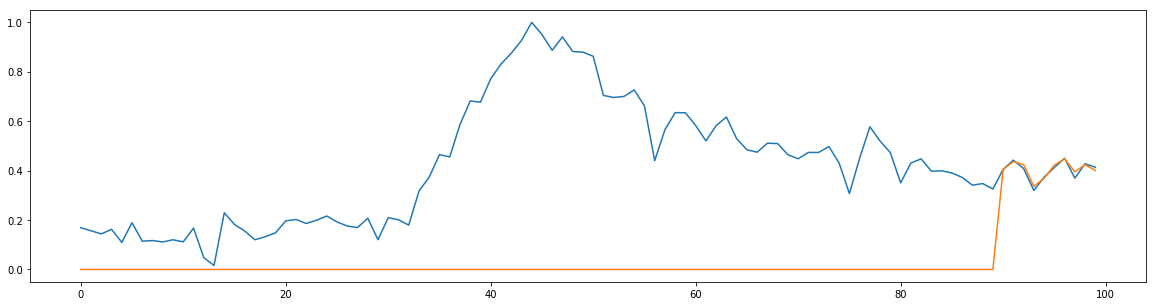

In [105]:
torch_model.eval()
i = random.randint(0, len(X_train))
example = X_train[i]
example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor')
pred = torch_model(example).detach().numpy()
combined = np.concatenate([example[0].numpy(), y_train[i].T], axis=0).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example.squeeze()),pred]).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

In [50]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping, Callback
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import os

Using TensorFlow backend.


In [111]:
nn_model = Sequential()
nn_model.add(Dense(
    256,
    input_shape=(None, 250)
))
nn_model.add(Activation('relu'))
nn_model.add(Dense(128))
nn_model.add(Activation('relu'))
nn_model.add(Dense(64))
nn_model.add(Activation('relu'))
nn_model.add(Dense(10))

nn_model.compile(loss='mse',
               optimizer='adam')
nn_model.fit(X_train, y_train, batch_size=64, epochs=500)

Epoch 1/500
300/300 [==============================] - 0s 1ms/step - loss: 0.2000
Epoch 2/500
300/300 [==============================] - 0s 53us/step - loss: 0.0834
Epoch 3/500
300/300 [==============================] - 0s 46us/step - loss: 0.0549
Epoch 4/500
300/300 [==============================] - 0s 55us/step - loss: 0.0436
Epoch 5/500
300/300 [==============================] - 0s 55us/step - loss: 0.0372
Epoch 6/500
300/300 [==============================] - 0s 53us/step - loss: 0.0329
Epoch 7/500
300/300 [==============================] - 0s 51us/step - loss: 0.0288
Epoch 8/500
300/300 [==============================] - 0s 58us/step - loss: 0.0284
Epoch 9/500
300/300 [==============================] - 0s 62us/step - loss: 0.0277
Epoch 10/500
300/300 [==============================] - 0s 62us/step - loss: 0.0254
Epoch 11/500
300/300 [==============================] - 0s 56us/step - loss: 0.0232
Epoch 12/500
300/300 [==============================] - 0s 56us/step - loss: 0.0220
Ep

In [114]:
model = Sequential()

model.add(LSTM(
    80,
    input_shape=(None, X_train.shape[2]),
    return_sequences=True)
)

model.add(Dropout(.3))

model.add(LSTM(
    80,
    return_sequences=False)
)

model.add(Dropout(.3))

model.add(Dense(10))

model.compile(loss='mse',
               optimizer='adam')

model.fit(X_train,
    y_train.squeeze(),
    batch_size=64,
    epochs=500,
    validation_split=.2,
)

Train on 240 samples, validate on 60 samples
Epoch 1/500
240/240 [==============================] - 1s 4ms/step - loss: 0.2812 - val_loss: 0.2214
Epoch 2/500
240/240 [==============================] - 0s 93us/step - loss: 0.2119 - val_loss: 0.1494
Epoch 3/500
240/240 [==============================] - 0s 87us/step - loss: 0.1452 - val_loss: 0.0956
Epoch 4/500
240/240 [==============================] - 0s 93us/step - loss: 0.1116 - val_loss: 0.0907
Epoch 5/500
240/240 [==============================] - 0s 98us/step - loss: 0.1051 - val_loss: 0.0861
Epoch 6/500
240/240 [==============================] - 0s 104us/step - loss: 0.0994 - val_loss: 0.0788
Epoch 7/500
240/240 [==============================] - 0s 104us/step - loss: 0.0906 - val_loss: 0.0770
Epoch 8/500
240/240 [==============================] - 0s 104us/step - loss: 0.0887 - val_loss: 0.0730
Epoch 9/500
240/240 [==============================] - 0s 106us/step - loss: 0.0862 - val_loss: 0.0667
Epoch 10/500
240/240 [============

In [70]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 80)          105920    
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 80)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_14 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                810       
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 158,250
Trainable params: 158,250
Non-trainable params: 0
________________________________________________

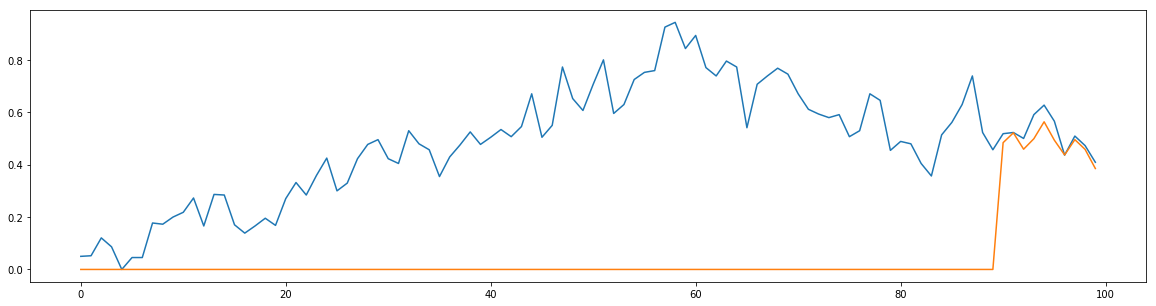

In [69]:
i = random.randint(0, X_train.shape[0])
example = X_train[i]
pred = model.predict(example.reshape(1,1,-1))
combined = np.concatenate([example,y_train[i]], axis=1).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

In [71]:
model.weights

[<tf.Variable 'lstm_13/kernel:0' shape=(250, 320) dtype=float32>,
 <tf.Variable 'lstm_13/recurrent_kernel:0' shape=(80, 320) dtype=float32>,
 <tf.Variable 'lstm_13/bias:0' shape=(320,) dtype=float32>,
 <tf.Variable 'lstm_14/kernel:0' shape=(80, 320) dtype=float32>,
 <tf.Variable 'lstm_14/recurrent_kernel:0' shape=(80, 320) dtype=float32>,
 <tf.Variable 'lstm_14/bias:0' shape=(320,) dtype=float32>,
 <tf.Variable 'dense_7/kernel:0' shape=(80, 10) dtype=float32>,
 <tf.Variable 'dense_7/bias:0' shape=(10,) dtype=float32>]

In [84]:
weights = model.get_weights()

In [86]:
torch.from_numpy(np.transpose(weights[0])).shape

torch.Size([320, 250])

In [88]:
list(torch_model.lstm1.parameters())

[Parameter containing:
 tensor([[-4.8413e-02],
         [ 2.2317e-02],
         [ 3.5249e-02],
         [-1.0856e-01],
         [-1.5444e-02],
         [-2.3786e-02],
         [ 2.5587e-02],
         [ 6.1045e-02],
         [ 3.5671e-02],
         [ 1.9390e-01],
         [-4.0002e-02],
         [ 3.0305e-02],
         [-1.5760e-02],
         [ 8.6382e-02],
         [ 1.5650e-01],
         [-8.4576e-03],
         [ 1.3139e-01],
         [-4.7507e-02],
         [ 6.5172e-02],
         [-3.6419e-02],
         [ 1.5163e-02],
         [-4.2161e-02],
         [ 1.1821e-01],
         [ 1.3961e-01],
         [ 1.4361e-01],
         [-1.1900e-01],
         [ 1.3945e-01],
         [-1.2035e-02],
         [ 7.7444e-02],
         [ 1.4917e-01],
         [ 1.7625e-01],
         [ 1.4309e-02],
         [-1.5466e-02],
         [ 1.4270e-02],
         [ 4.8904e-02],
         [ 4.8180e-02],
         [-4.7263e-02],
         [ 6.8557e-02],
         [ 1.4053e-01],
         [ 4.9546e-02],
         [-1.9304